# CSE 891 Project Part 2: Data Analysis

### Due date: December 13, 2020 (before midnight)

For this project, your objective is to perform link prediction, community detection, and clsasification of the nodes in the network. Use this Jupyter notebook template for your program. Save it as part2.ipynb and submit it (along with its HTML version) to D2L.

## C. DATA ANALYSIS

For this step, you will write code for applying machine learning to the network data.

**Step 1.** Load the 'coauthor.csv' file you have created in Part 1 into a dataframe object called coauthors. The dataframe should have 2 columns, named Node0 and Node1, respectively. Next, create a 2-dimensional (dense) array called *adjmatrix* from the coauthors dataframe. Since there are 165 authors, the adjmatrix matrix is of size 165 x 165. 

**Caution:** The author ID index starts from 1 but the adjmatrix array has indices that start from 0. Make sure you subtract the author ID by 1 before inserting it into the appropriate entry in the adjmatrix. 

In [391]:
import pandas as pd
import numpy as np

coauthors = pd.read_csv('coauthor.csv', delimiter=',', header=None, names=['Node0', 'Node1'])

coauthors.head()

,Node0,Node1
0,101,136
1,136,101
2,19,106
3,106,19
4,139,29


In [392]:
df = pd.DataFrame(np.zeros((165, 165)))

for i in range(coauthors.shape[0]):
    authID1 = coauthors['Node0'][i]
    authID2 = coauthors['Node1'][i]
    df[authID1-1][authID2-1] = 1

adjmatrix = np.array(df.values.tolist())

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(adjmatrix)

adjmatrix

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

**Step 2:** For this step, you will visualize the network given by the coauthors dataframe. See the example below on how to display a network from a pandas DataFrame using the networkx library. When plotting larger graphs, you should consider varying the node size according to the node degree so that nodes with large number of links appear to be more visible. For more information about networkx, you may refer to the documentation available at https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html. You can use the sample code below to test the different options available for drawing the network using the networkx library. For example, you can tune the scale and threshold parameter of the spring_layout and observe how it affects the displayed network.

**(a)** Sample code (for testing your visualization code)

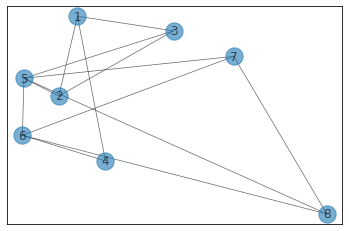

In [393]:
import networkx as net
import matplotlib.pyplot as plt
%matplotlib inline

nodes = [1,2,3,4,5,6,7,8]
edges = [[1,2],[1,3],[1,4],[2,3],[2,5],[3,5],[4,6],[5,6],[5,7],[5,8],[6,7],[6,8],[7,8]]
edges2 = edges + [[a[1],a[0]] for a in edges]
nodepairs = pd.DataFrame(edges2, columns=['Node0', 'Node1'])

G = net.from_pandas_edgelist(nodepairs, "Node0", "Node1", create_using=net.Graph())
plt.figure(figsize=(6,4))
pos = net.spring_layout(G, scale=5, threshold=0.1)
net.draw_networkx(G, with_labels=True, pos = pos, node_size = 300, alpha = 0.6, width = 0.7)
plt.show()

**(b)** Provide the actual code for plotting the coauthorship network below. Your result may be different than the network shown here.

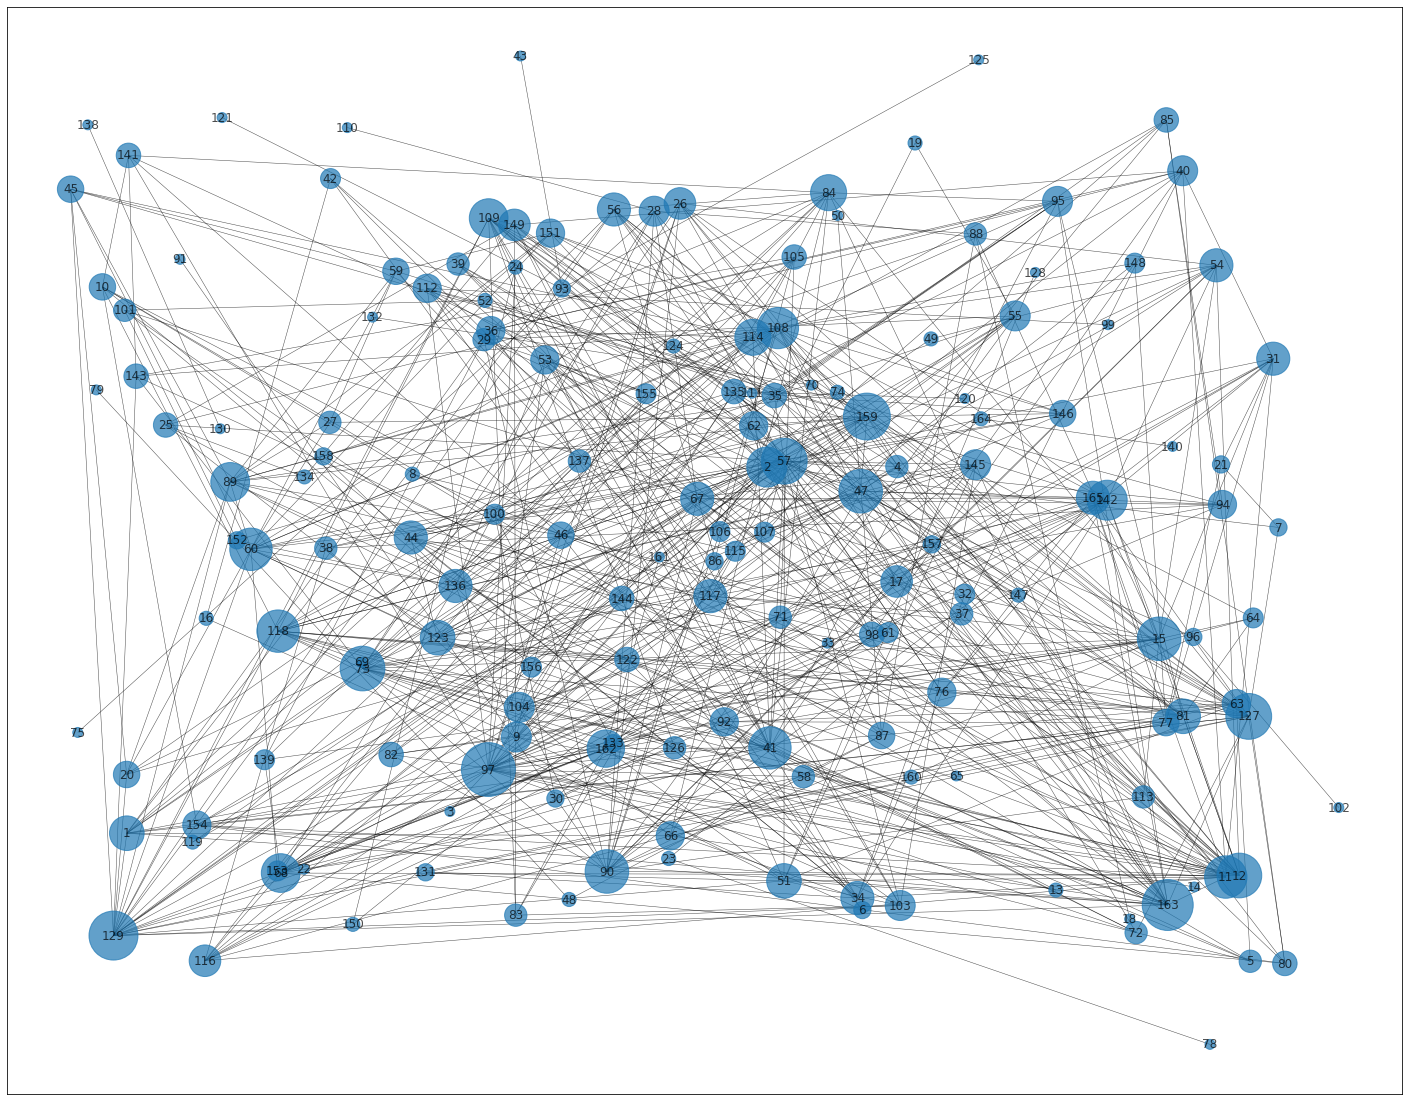

In [396]:
import networkx as net
import matplotlib.pyplot as plt
%matplotlib inline

G = net.from_pandas_edgelist(coauthors, "Node0", "Node1", create_using=net.Graph())
plt.figure(figsize=(25,20))
pos = net.spring_layout(G, scale=10, threshold=0.01)
d = dict(G.degree)
node_size = [v * 100 for v in d.values()]
net.draw_networkx(G, with_labels=True, pos = pos, node_size = node_size, alpha = 0.7, width = 0.5)
plt.show()

**Step 3 (Link Prediction):** For this step, you will develop an algorithm to predict missing links in a network. Link prediction can be used to recommend new links in a network as well. The network is represented by a set of node pairs, which could be linked ($y=1$) or unlinked ($y=0$). Each node pair $(i,j)$ is associated with a set of features ($\mathbf{x}(i,j)$), which will be used as predictor attributes to classify the node pair. For this task, you need to create a data matrix for $\mathbf{X}$ and class vector $\mathbf{y}$ as shown by the example below (the values in the matrix/vector are hypothetical):

$$\mathbf{X}: \begin{bmatrix}
0.1 & -0.3 & \cdots & 0.2\\
0.2 & 0.1 & \cdots & 0.1\\
\cdots & \cdots & \cdots & \cdots \\
0.1 & -0.1 & \cdots & 0.3\\
\end{bmatrix}, \ \ \ 
\mathbf{y}: \begin{bmatrix}
1 \\ 0 \\ \cdots \\ 0
\end{bmatrix},$$

where each row corresponds to the feature vector or class label of a node-pair. Since the network is an undirected graph (and its adjacency matrix is symmetric), to avoid generating duplicates, you only need to generate each node pair once in $\mathbf{X}$ and $\mathbf{y}$. For example, a network with 4 nodes will produce a matrix $\mathbf{X}$ and vector $\mathbf{y}$ that has 6 rows each, one for every node pair $(1,2),(1,3),(1,4),(2,3),(2,4),(3,4)$. The description on how to create the feature vector $\mathbf{x}$ for each node pair is described in part (b) below. Once you have created $\mathbf{X}$ and $\mathbf{y}$, you will pass them to a logistic regression classifier to train the link prediction model.

**(a)** For evaluation purposes, you need to discard some of the links in the original network to convert them into missing links that must be predicted by the link prediction algorithm. The modified network with missing links thus becomes the training network while the original network without missing links becomes the test network.
To do this, you will need to write your own implementation of the train_test_split() function for the network data. The function takes 3 input parameters: 
- *adjmatrix*, the adjacency matrix of the original (complete) network, 
- *test_size*, which corresponds to the fraction of links in the original network to be eliminated, 
- *random_state*, which is the seed for random number generator. 

The train_test_split() function will randomly select (test_size $\times 100$%) of the non-zero values in the input adjacency matrix $\textbf{A}$ and convert them from 1 to 0 (non-links). It will then return the modified adjacency matrix as output of the function. Make sure the modified adjacency matrix returned by the function is symmetric. Thus, if the link associated with $\textbf{A}(1,2)=1$ was selected to be discarded, the function will set $\textbf{A}(1,2)=0$ as well as $\textbf{A}(2,1)=0$. You will use the modified network with missing links to train your link prediction algorithm and the original (complete) network as your test set to evaluate how well the algorithm can recover the missing links. 

In [397]:
def train_test_split(adjmatrix, test_size=0.2, random_state=1):
    
    from copy import copy, deepcopy
    modified_matrix = deepcopy(adjmatrix)
    nonzero = np.nonzero(modified_matrix)
    nonzero_row = nonzero[0]
    nonzero_col = nonzero[1]
    np.random.seed(random_state)
    indices = np.random.choice(len(nonzero_row), int(len(nonzero_row)*test_size), replace=False)
    for ind in indices:
        modified_matrix[nonzero_row[ind]][nonzero_col[ind]]= 0.0
        modified_matrix[nonzero_col[ind]][nonzero_row[ind]]= 0.0

    return modified_matrix

You may use the validateTestSplit() function and sample code below to make sure your function works correctly. 

In [398]:
import numpy as np

def validateTestSplit(original_matrix, modified_matrix):
    links = np.where(original_matrix > 0)
    print('Number of links in original graph x 2 =', len(links[0]))
    
    diff = original_matrix - modified_matrix
    if len(diff[0]) < 0:
        print('Error: modified matrix contains unknown links')
        return False
    missing = np.where(diff > 0) 
    print('Number of missing links x 2 =', len(missing[0]))
    print('Percent removed =', len(missing[0])/len(links[0]))    
    
print('Original adjacency matrix')
A = np.array([[0,1,1,1,2],[1,0,4,1,2],[1,4,1,1,3],[0,1,1,0,2],[2,2,3,2,0]])
print(A)

print('\nModified adjacency matrix')
A2 = train_test_split(A,0.3,2)
print(A2)

validateTestSplit(A, A2)

Original adjacency matrix
[[0 1 1 1 2]
 [1 0 4 1 2]
 [1 4 1 1 3]
 [0 1 1 0 2]
 [2 2 3 2 0]]

Modified adjacency matrix
[[0 0 1 1 2]
 [0 0 0 1 2]
 [1 0 1 1 0]
 [0 1 1 0 2]
 [2 2 0 2 0]]
Number of links in original graph x 2 = 20
Number of missing links x 2 = 6
Percent removed = 0.3


Use the code below to create the test network for your evaluation by eliminating some of the links in the original network.

In [399]:
modified_matrix = train_test_split(adjmatrix, 0.15)
validateTestSplit(adjmatrix, modified_matrix)

Number of links in original graph x 2 = 1150
Number of missing links x 2 = 324
Percent removed = 0.2817391304347826


In [400]:
check_symmetric(modified_matrix)

True

**(b)** For this question, you need to develop a link prediction class named *linkpred* to predict missing links in the incomplete (training) network created in part (a). The class consists of the following 3 parts:
- A **representation learning** function to learn the feature vector of each node in the network. Specifically, the function will convert the input $N \times N$ adjacency matrix into an $N \times k$ feature representation matrix $\mathbf{V}$, where $N$ is the number of nodes and $k$ is the desired feature dimension (default value is $k=5$). To do this, you must perform eigenvalue decomposition on the adjacency matrix and extract the eigenvectors corresponding to the top-$k$ largest eigenvalues to form the feature representation matrix $\mathbf{V}$ of the nodes in the network. You may use *numpy.linalg* package to compute the eigenvalues and eigenvectors of a matrix. The representation learning function should be automatically invoked when the *linkpred* object is initialized. 
- **Link feature construction**, which uses the learned feature representation $\mathbf{V}$ of each node to derive the feature representation of each link in an input network. Use the absolute difference of the feature vectors between 2 nodes to compute the feature vector of a node pair. For example, if $\mathbf{v}_i = [1,2,2]$ and $\mathbf{v}_j = [2,2,1]$ represent the feature vector of nodes $i$ and $j$ respectively, then the feature vector for the node pair $(i,j)$ is equal to:
$$\mathbf{x}(i,j) = | \mathbf{v}_i - \mathbf{v}_j | = [ | 1-2 |, | 2-2 |, | 2-1 |] = [1, 0, 1]$$
Given an adjacency matrix of size $N \times N$ as input, the function will return (1) a matrix $\mathbf{X}$ of size $N(N-1)/2 \times k$, where $k$ is the number of desired feature dimensions, and (2) a vector $\mathbf{y}$ of length $N (N-1)/2$ that indicates whether there is a link or not. The first row in $\mathbf{X}$ corresponds to the link features for the node pair $(1,2)$, i.e., $\mathbf{x}(1,2)$, the second row is for $\mathbf{x}(1,3)$, and so on, until the last row corresponds to the link features for the node pair $(N,N-1)$, i.e., $\mathbf{x}(N,N-1)$. This is illustrated in the diagram below:
$$\textrm{Adjacency matrix}: \begin{bmatrix}
0 & 1 & 0 & \cdots & 0\\
1 & 0 & 0 & \cdots & 0\\
\cdots & \cdots & \cdots & \cdots & \cdots\\
0 & 0 & 0 & \cdots & 0
\end{bmatrix} \  \Longrightarrow \ 
\textrm{Link feature}, \mathbf{X}:  
\begin{bmatrix}
0.1 & -0.3 & \cdots & 0.2\\
0.2 & 0.1 & \cdots & 0.1\\
\cdots & \cdots & \cdots & \cdots \\
0.1 & -0.1 & \cdots & 0.3\\
\end{bmatrix}
\begin{matrix}
\leftarrow (1,2) \rightarrow \\ \leftarrow (1,3) \rightarrow \\ \cdots \\ \leftarrow (N,N-1) \rightarrow\\
\end{matrix}
\begin{bmatrix}
1\\ 0 \\ \cdots \\ 0
\end{bmatrix}
\leftarrow \mathbf{y}
$$
- **Link classification**, which applies a logistic regression classifier to predict the missing links based on the provided link features. One problem with training a classifier for link prediction is that the number of linked node pairs is considerably smaller than the number of non-linked node pairs. This produces a class imbalanced problem (i.e., there are more node pairs with $y=0$ than those with $y=1$). To circumvent this problem, you need to write a function called stratify() that returns a more balanced data set with equal number of linked and non-linked node pairs. For example, if the network has 100 links and 900 non-links, the function will randomly select 100 out of the 900 non-linked node pairs to be combined with all 100 linked pairs and return the corresponding $\mathbf{X}$ matrix and $\mathbf{y}$ vector, each containing 200 rows (100 linked and 100 non-linked pairs). This approach is known as stratification by undersampling the majority class. The link classification part will be implemented using the fit() and predict() functions described below:
    - fit() takes the predictor $\mathbf{X}$ matrix and target $\mathbf{y}$ vector as input to  fit a logistic regression model to the training data. It will call the stratify() function first to ensure the data is balanced before training the logistic regression model.
    - predict() takes as input a predictor matrix $\mathbf{X}$ as its test set and applies the trained logistic regression model to predict the classes of each row in $\mathbf{X}$. It will return a vector of the predicted classes as its output.

In [401]:
import numpy as np
import numpy.linalg as linalg
from scipy.sparse.linalg import eigsh
from sklearn.linear_model import LogisticRegression

class linkpred():
    """
    Implementation of link prediction algorithm
    """
    def __init__(self, adjmatrix, feature_dim = 40):
        """ 
        In this function, you need to
           1. Store the adjmatrix  and feature dimension into 2 self variables, self.adjmatrix and self.feature_dim
           2. Call the representation_learning() function to generate the feature representation of the nodes.
        """
        self.adjmatrix = adjmatrix
        self.feature_dim = feature_dim
        self.representation_learning()
        
    def representation_learning(self):
        """ 
        In this function, you need to compute the top-k eigenvectors of the adjacency matrix, where k is 
        the number of feature dimensions. Save the resulting eigenvectors as a private (self) variable.
        """
        evals, evecs = eigsh(self.adjmatrix, k=self.feature_dim, which="LA")
        idx = evals.argsort()[::-1]   
        eigenValues = evals[idx]
        eigenVectors = evecs[:,idx]
        
        self.eigvectors = eigenVectors
        
    def link_construction(self, adjmatrix):
        """ 
        In this function, compute the link features for every pair of nodes in the input adjacency matrix 
        using the node features extracted by the representation_learning function. The function should return  
        a link feature matrix X of size N(N-1)/2 x k and class label vector y of length N(N-1)/2, where N is
        the number of nodes in the network.
        """
        
        adjmat = adjmatrix
        featureVectors = self.eigvectors
        N = featureVectors.shape[0]
        x_rows = int(N*(N-1)/2)
        X = np.zeros([x_rows,featureVectors.shape[1]])
        y = np.zeros([x_rows])
        i=0
        j=0
        while j!=N-1:
            for k in range(j+1, N):
                X[i,:] = np.absolute(np.array(featureVectors[j]) - np.array(featureVectors[k]))
                y[i] = adjmat[j][k]
                i+=1
            j+=1

        return X, y
        
    def stratify(self, X, y, random_state=1):
        """ 
        In this function, you need to perform stratification by undersampling the larger class. Since there are
        more unlinked node pairs than linked node pairs in the network, you need to randomly select a subset of the
        unlinked node pairs to generate a sample of equal number of linked and non-linked pairs. The function takes
        as input a matrix X and vector y, while returning the row index of the stratified samples chosen. For example,
        if there are 10 data points, with y = [1,1,0,0,0,0,1,0,0,0], the function may return the array
        [0,1,4,5,6,9] as its output. This array allows us to choose rows 1,2,5,6,7 and 10 to generate a balanced 
        training data with equal number of points for y=1 and y=0.
        """
        number_of_ones = np.count_nonzero(y)
        nonzero_indices = np.where(y == 1)[0]
        all_zero_indices = np.where(y == 0)[0]
        np.random.seed(random_state)
        zero_indices = np.random.choice(all_zero_indices, number_of_ones, replace=False)
        stratified_indices = np.concatenate([zero_indices,nonzero_indices])
        
        return stratified_indices
        
    def fit(self, X, y):
        """ 
        In this function, you need to apply the stratify() function to the matrix X and vector y previously generated 
        by the link_construction function. It will then apply the logistic regression model to the stratified X and y.
        The resulting model should be saved in a private (self) variable named self.model.
        """        
        ind = self.stratify(X,y)
        
        self.model = LogisticRegression(random_state=1,penalty='none',C=1.0).fit(X[ind], y[ind])
        
    def predict(self, X):
        """ 
        In this function, apply the saved regression model (self.model) to the input test data. Return
        the predicted class of each row in X.
        """        
        predictions = self.model.predict(X)
        
        return predictions

**(i)** Use the code below to generate the predicted links.

In [402]:
G = linkpred(modified_matrix)
X, y = G.link_construction(modified_matrix)   # Generates link features for training network 
G.fit(X, y)
yhat = G.predict(X)        # Generates the predicted class for training data

Xtest, ytest = G.link_construction(adjmatrix) # Generates link features for test network
yhat2 = G.predict(Xtest)   # Generates the predicted class for test network

**(ii)** Use the code below to evaluate the performance of your model.

In [403]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Training Accuracy:', accuracy_score(y, yhat)*100, '%')
print(confusion_matrix(y, yhat))

print('Test Accuracy:', accuracy_score(ytest, yhat2)*100, '%')
print(confusion_matrix(ytest, yhat2))

Training Accuracy: 64.09460458240946 %
[[8376 4741]
 [ 117  296]]
Test Accuracy: 63.96156688839616 %
[[8286 4669]
 [ 207  368]]


**Step 4 (Community Detection):** For this step, you will apply a community detection algorithm to partition the co-authorship network into a set of communities (clusters). The community detection algorithm to be used here is called network modularity algorithm. The algorithm consists of the two following steps:
- Generate a feature representation of each node by maximizing the following objective function, called modularity:
$$Q = \frac{1}{4m} \sum_{ij} \bigg(A_{ij} - \frac{d_i d_j}{2m}\bigg) c_i c_j,$$
where $d_i$ and $d_j$ are the degrees of node $i$ and node $j$ respectively, $m$ is the total number of links in the network, while $c_i$ and $c_j$ are the cluster membership. It can be shown that maximizing the modularity measure is equivalent to finding the top $k$ eigenvectors of the following matrix:
$$\mathbf{B} = \mathbf{A} - \frac{1}{2m} \mathbf{d}\mathbf{d}^T,$$
where $\mathbf{A}$ is the adjacency matrix and $\mathbf{d}$ is a vector of the node degrees. Use the eigenvectors $\mathbf{v}_1, \mathbf{v}_2, \cdots, \mathbf{v}_k$ corresponding to the top-$k$ largest eigenvalues of $\mathbf{B}$ to form the following matrix
$$\mathbf{U} = \begin{bmatrix}
| & | & \cdots & | \\
\mathbf{v}_1 & \mathbf{v}_2 & \cdots & \mathbf{v}_k \\
| & | & \cdots & | \\
\end{bmatrix}$$
The resulting matrix $\mathbf{U}$ will have dimension $N \times k$, where $N$ is the total number of nodes and $k$ is the desired number of clusters. 
- Apply k-means clustering to the matrix $\mathbf{U}$ to obtain the final $k$ clusters. 

Set the number of clusters to be 5 and display the names of authors belonging to each cluster. To do this, you must first load the author names and save it in a list named authors.   

**(a)** First, load the authors.txt file and store the author names into a list.

In [404]:
authors = []
with open("authors.txt") as f:
    for line in f:
        splitted = line.strip().split(' ')
        name = " ".join(splitted[1:])
#         value = splitted[0] 
        authors.append(name)

print (authors)


['Aaron C. Courville', 'Alan L. Yuille', 'Alan S. Willsky', 'Alex Krizhevsky', 'Alex Smola', 'Alexandre Gramfort', 'Ali Farhadi', 'Anders Krogh', 'Andrea Vedaldi', 'Andrew McCallum', 'Andrew Y. Ng', 'Andrew Zisserman', 'Armando Fox', 'Arnaud Doucet', 'Bernt Schiele', 'Bertrand Thirion', 'Bill Triggs', 'Bing Liu', 'Bram van Ginneken', 'Carl Edward Rasmussen', 'Carlos Guestrin', 'Chih-Jen Lin', 'Chin-Hui Lee', 'Chris H. Q. Ding', 'Christian Szegedy', 'Christopher M. Bishop', 'Corinna Cortes', 'Dacheng Tao', 'Daniel Cremers', 'Daniele Bonacorsi', 'Daphne Koller', 'David Heckerman', 'David Jones', 'David M. Blei', 'David Silver', 'David Warde-Farley', 'Deva Ramanan', 'Diederik P. Kingma', 'Dimitris N. Metaxas', 'Dragomir Anguelov', 'Dumitru Erhan', 'Fabian Pedregosa', 'Fedor Ratnikov', 'Fei-Fei Li 0001', 'Fernando Pereira', 'Francis Bach', 'Geoffrey E. Hinton', 'Geoffrey Ye Li', 'Georgios B. Giannakis', 'Gong Zhang', 'Greg Corrado', 'Guang-Bin Huang', 'Guillermo Sapiro', 'Hermann Ney', 'Ho

**(b)** Create a class named *community_detection* to perform network modularity clustering. The class contains the following 3 functions:
- An initialization function that takes 3 input parameters: adjacency matrix, list of author names (from part (a)), and number of clusters. The initialization function will assigned them to the self (private) variables. It will then invoked the representation_learning function to compute the node features.
- A representation learning function that computes the unnormalized modularity matrix B (see formula shown above in Step 4) from the adjacency matrix. It will then perform eigenvalue decomposition on B to extract the top-k eigenvectors, where k is the same as the desired number of clusters.
- A fit() function to apply k-means clustering. It will then display the clustering results after mapping each node to the author names.

**(i)** Below a sample code for k-means clustering to generate 3 clusters. Use this sample code for testing purposes only.

In [405]:
from sklearn.cluster import KMeans

X = np.array([1.3, 5.3, 10.1, 2.1, 5.6, 6.1, 0.9, 11.2]).reshape((-1,1))
print(X)
nodelabels = ['John', 'Mary', 'Bob', 'Lisa', 'Bill', 'Ryan', 'Joe', 'Jim']
numClusters = 3

clusters = KMeans(n_clusters=numClusters, random_state=1).fit(X)
# The cluster label of each point is stored in clusters.labels_ 

for i in range(len(X)):
    print(nodelabels[i], 'is assigned to cluster', clusters.labels_[i])

[[ 1.3]
 [ 5.3]
 [10.1]
 [ 2.1]
 [ 5.6]
 [ 6.1]
 [ 0.9]
 [11.2]]
John is assigned to cluster 2
Mary is assigned to cluster 0
Bob is assigned to cluster 1
Lisa is assigned to cluster 2
Bill is assigned to cluster 0
Ryan is assigned to cluster 0
Joe is assigned to cluster 2
Jim is assigned to cluster 1


**(ii)** Write your implementation of the community_detection class below.

In [408]:
from sklearn.cluster import KMeans

class community_detection():
    """
    Implementation of community detection algorithm
    """
    
    def __init__(self, adjmatrix, nodeLabels, numClusters = 5):
        """ 
        In this function, you need to
           1. Store the adjmatrix, numClusters, and node labels into 3 self variables, self.adjmatrix,
              self.nodelabels, and self.numClusters
           2. Call the representation_learning() function to generate the feature representation of the nodes.
        """
        self.adjmatrix = adjmatrix
        self.nodeLabels= nodeLabels
        self.numClusters = numClusters
        
        self.representation_learning()
        
    def representation_learning(self):
        """ 
        In this function, you need to
           1. Compute a degree vector of the nodes, d, and total number of links in the network, m. 
           2. Compute the matrix B = A - dd^T/2m.
           3. Compute the top-k eigenvectors of B, where k is number of clusters (self.numClusters).
           4. Generate a matrix U by concatenating the eigenvectors of B column-wise. 
        """
        numNodes = np.count_nonzero([np.count_nonzero(self.adjmatrix[i]) for i in range(np.array(self.adjmatrix).shape[0])])
        m = (np.count_nonzero(self.adjmatrix))/2
        vector_ones = np.ones(numNodes)
        degree_vec = np.dot(adjmatrix, vector_ones)
        
        B = self.adjmatrix - (1/(2*m))*np.dot(degree_vec.T,degree_vec)
        
        evals, evecs = eigsh(B, k=self.numClusters, which="LA")
        idx = evals.argsort()[::-1]   
        eigenValues = evals[idx]
        self.eigenVectors = evecs[:,idx]
     
    def fit(self, random_state=1):
        """
        1. Apply k-means clustering to the matrix , setting the number of clusters equal to self.feature_dim.
        2. Map the cluster labels to the author names and display the members of each cluster. 
        """
        clusters = KMeans(n_clusters=self.numClusters, random_state=1).fit(self.eigenVectors)
        # The cluster label of each point is stored in clusters.labels_ 
        print("Community detection results:",)
        
        dicts = {}
        author_names = np.array(self.nodeLabels)
        for i in range(clusters.n_clusters):
            key = "Community " + str(i) 
            dicts[key] = list(author_names[np.array(np.where(clusters.labels_ == i)[0]).tolist()])
    
        for key,value in dicts.items():
            print (key, ":", value, "\n")
            


**(iii)** Test your community detection algorithm. Use this output as a guide on how to display the results only.  Your results can be different than this. 

In [410]:
community_detection(adjmatrix, authors, numClusters=5).fit()

Community detection results:
Community 0 : ['Alan L. Yuille', 'Alan S. Willsky', 'Alex Krizhevsky', 'Alex Smola', 'Alexandre Gramfort', 'Ali Farhadi', 'Anders Krogh', 'Andrea Vedaldi', 'Andrew McCallum', 'Armando Fox', 'Arnaud Doucet', 'Bertrand Thirion', 'Bing Liu', 'Bram van Ginneken', 'Carlos Guestrin', 'Chih-Jen Lin', 'Chin-Hui Lee', 'Chris H. Q. Ding', 'Christian Szegedy', 'Dacheng Tao', 'Daniel Cremers', 'Daniele Bonacorsi', 'Daphne Koller', 'David Heckerman', 'David Jones', 'David M. Blei', 'David Silver', 'Deva Ramanan', 'Diederik P. Kingma', 'Dimitris N. Metaxas', 'Dragomir Anguelov', 'Fabian Pedregosa', 'Fedor Ratnikov', 'Fei-Fei Li 0001', 'Francis Bach', 'Geoffrey Ye Li', 'Georgios B. Giannakis', 'Gong Zhang', 'Guang-Bin Huang', 'Guillermo Sapiro', 'Horst Bischof', 'Inderjit S. Dhillon', 'Javier M. Duarte', 'Jean Ponce', 'Jeff Dean', 'Jeff Donahue', 'Jianming Zhang', 'Jiri Matas', 'Jitendra Malik', 'Johan A. K. Suykens', 'Johannes Brandstetter', 'John C. Platt', 'John Langfo